<img src="./img/vs265header.svg"/>

<h1 align="center">Lab 4 - Sparse, Distributed Representations</h1>

Group Members:


In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import utils.plotFunctions as pf
import utils.helperFunctions as hf

## 1 - Sparse Coding of Bars dataset using the locally competitive algorithms (LCA)

In this problem we will implement the Sparse Coding Algorithm and run it on a modified version of the bars dataset (i.e., where the bars superimpose additively rather than by logical 'or' as in Foldiak's dataset). The algorithm we will use to compute the sparse activations is the Locally Competitive Algorithm (LCA), which is described in the handout "Sparse coding via LCA" on the website (see also Rozell et al. (2008) under "further readings" for more background).

The goal in this problem is for the Sparse Coding algorithm to learn the causal structure of the data - i.e., the bars. To implement the algorithm you must:

* Fill in the LCA equations in the `inference` function.

* Fill in the $\phi$ update learning rule in the `updateWeights` function.

* Adjust the $\lambda$ parameter to find the right sparity level.

Note that while the bars dataset is composed of only dark (positive) bars, your weights may converge to either light or dark bars because each neuron can have either positive or negative activity, as we discussed in class. What's important is the form of the solution, the sign is arbitrary.


<IPython.core.display.Javascript object>


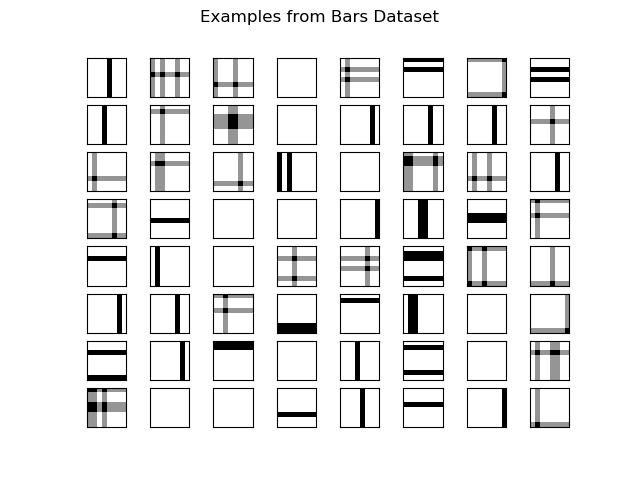

In [78]:
# Generate the Bars Dataset and look at it.
numInputs = 64  # Must be equal to some integer squared (e.g. 8**2 = 64).
numDataPoints = 10000
probabilityOn = 0.1
bars_dataset = hf.genAdditiveBars(numInputs, numDataPoints, probabilityOn)

pf.plotDataTiled(bars_dataset[:, :64], "Examples from Bars Dataset");

In [79]:
# Sparse Coding hyperparameters
numTrials = 2500  # Number of weight update steps
numOutputs = 16  # Number of neurons, there are only 16 possible bars in the generative model
lambdav = 0.2
batchSize = 100  # Number of samples to use in a single weight update
eta = 0.1  # Learning rate

# Inference hyperparameters
tau = 10 # LCA update time constant
numInferenceSteps = 20 # Number of iterations to run LCA

# Plot display parameters
displayInterval = 50  # How often to update display plots during learning
displayStatsInterval = 50  # How often to update the stats plots

In [67]:
def threshold(u, lambdav):                                                                                                                                                                                                          
    """   
    Compute the activity of the neurons using the membrane potentials (u) using soft thresholding:                                                                                                                                           
                                                                                                                                                                                                                                         
    a = T(u) = u - threshold, u > threshold                                                                                                                                                                                              
               u + threshold, u < -threshold                                                                                                                                                                                             
               0, otherwise                                                                                                                                                                                                              
    """
    a = np.abs(u) - lambdav                                                                                                                                                                                                            
    a[np.where(a<0)] = 0                                                                                                                                                                                                                 
    a = np.sign(u) * a                                                                                                                                                                                                                   
    return a


def inference(dataBatch, phi, tau, labmbdav, numInferenceSteps):
    """
    Compute

    Parameters
    ----------
    dataBatch : Batch of data samples, shape=(numInputs, batchSize) 
    phi : Dictionary, shape=(numInputs, numOutputs)
    tau : Time Constant of LCA update, scalar float
    lambdav : Both the sparsity tradeoff term and the LCA Threshold value
    numInferencSteps: Number of inference steps to take
    
    Returns
    -------
    a : Activity, i.e. thresholded potentials, shape=(numOutputs, batchSize)
    """
    b = phi.T @ dataBatch # Driving input
    gramian = phi.T @ phi - np.identity(int(phi.shape[1])) # Explaining away matrix
    u = np.zeros_like(b) # Initialize membrane potentials to 0
    
    for step in range(numInferenceSteps):
        a = threshold(u, lambdav) # Activity vector contains thresholded membrane potentials
        du = b - gramian @ a - u #np.identity above takes care of i = j case
        u += (1.0 / tau) * du # Update membrane potentials using time constant
    return threshold(u, lambdav)


def weightUpdate(phi, dataBatch, activity, learningRate):
    dataBatchReconstruction = phi @ activity
    reconstructionError = dataBatch - dataBatchReconstruction
    dPhi = reconstructionError @ activity.T
    
    phi = phi + learningRate * dPhi # Scale weight update by learning rate
    return (phi, reconstructionError)

In [80]:
def trainModel(dataset, dataset_name):
    # Plotting
    sumPercentNonZero, sumEnergy, sumReconstructionQualitySNR = 0, 0, 0
    
    # Initialize Phi weight matrix with random values
    phi = hf.l2Norm(np.random.randn(numInputs, numOutputs))

    prevFig = pf.plotDataTiled(phi, "Dictionary at time step 0", None)
    statsFig, statsAxes = pf.plotStats(numTrials)
    # Do sparse coding with LCA
    for trial in range(numTrials):
        # Make batch of random image
        dataBatch = np.zeros((numInputs, batchSize))
        for batchNum in range(batchSize):
            if dataset_name == "bars":
                dataBatch[:, batchNum] = dataset[:, np.random.randint(dataset.shape[1])]
            else:
                dataBatch[:, batchNum] = hf.getRandomPatch(dataset, int(np.sqrt(numInputs)))

        # Compute sparse code for batch of data samples
        activity = inference(dataBatch, phi, tau, lambdav, numInferenceSteps)

        # Update weights using inferred  sparse activity
        learningRate = eta / batchSize
        (phi, reconstructionError) = weightUpdate(phi, dataBatch, activity, learningRate)

        # Renormalize phi matrix
        phi = hf.l2Norm(phi)

        # Record some stats for plotting
        percentNonZero, energy, reconstructionQualitySNR = (
            hf.computePlotStats(activity, reconstructionError, lambdav))
        sumPercentNonZero += percentNonZero
        sumEnergy += energy
        sumReconstructionQualitySNR += reconstructionQualitySNR

        # Update dictionary plot
        if trial and trial % displayInterval == 0:
            prevFig = pf.plotDataTiled(phi, "Dictionary at time step "+str(trial), prevFig)
            
        if trial and trial % displayStatsInterval == 0:
            avgEnergy, avgPercentNonZero, avgReconstructionQualitySNR = (
                sumEnergy/ displayStatsInterval, sumPercentNonZero / displayStatsInterval, 
                sumReconstructionQualitySNR / displayStatsInterval)
            pf.updateStats(statsFig, statsAxes, trial, avgEnergy, avgPercentNonZero, avgReconstructionQualitySNR)
            sumPercentNonZero = 0
            sumEnergy = 0
            sumReconstructionQualitySNR = 0

<IPython.core.display.Javascript object>


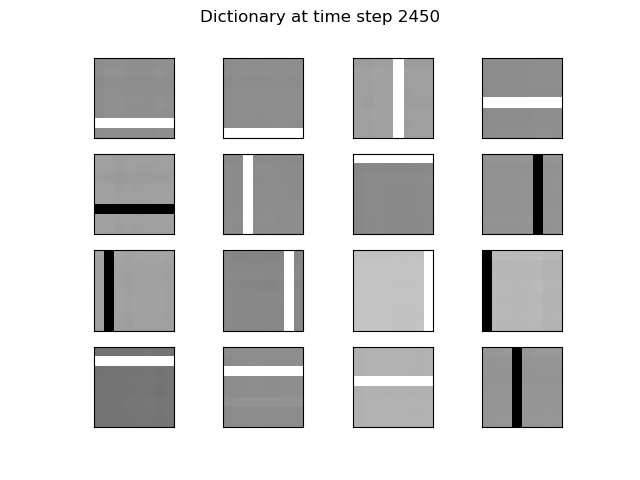

<IPython.core.display.Javascript object>


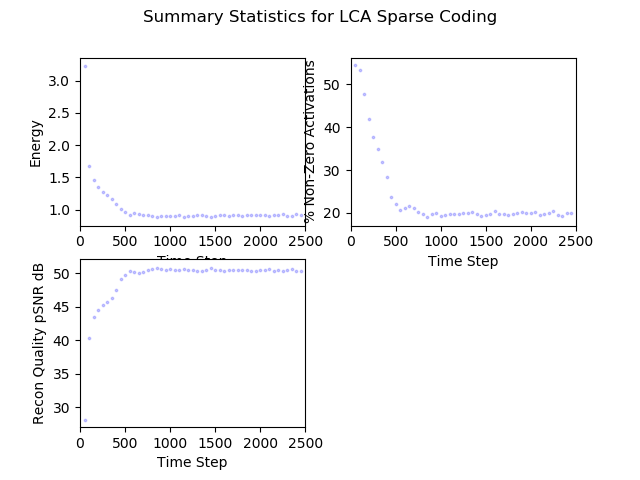

In [81]:
trainModel(bars_dataset, "bars")

Comment on the solution that is learned and its relation to the structure of the data.  Does it make sense?  Why wouldn't PCA be able to learn this solution? <b>Answer:</b> The learned basis functions are solid horizontal and vertical bars.  This makes sense because each of the dataset images is a superposition of several horizontal/vertical bars, so this basis is optimal for achieving a sparse representation (the number of active neurons needed for reconstruction corresponds to the number of superimposed bars in a given image). According to Bruno, PCA is incapable of learning about localized, oriented structure in images---which is precisely the type of image structure we generated.  

Try regenerating the dataset with `probabilityOn=0.5` so that the data no longer has sparse structure (i.e., the generative model from which the data were data created is no longer sparse). 

<IPython.core.display.Javascript object>


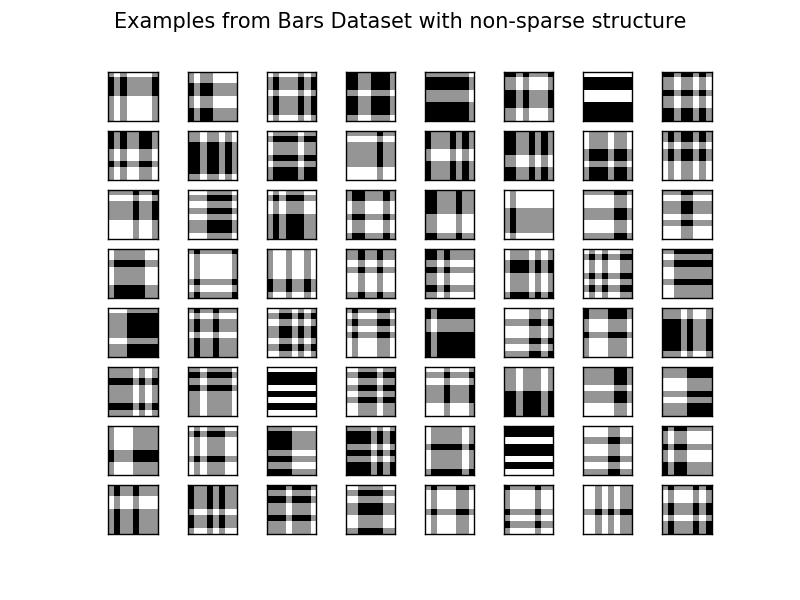

In [47]:
# Generate the non-sparse Bars Dataset and look at it.
numInputs = 64  # Must be equal to some integer squared (e.g. 8**2 = 64).
numDataPoints = 10000
probabilityOn = 0.5
bars_dataset = hf.genAdditiveBars(numInputs, numDataPoints, probabilityOn)

pf.plotDataTiled(bars_dataset[:, :64], "Examples from Bars Dataset with non-sparse structure");

<IPython.core.display.Javascript object>


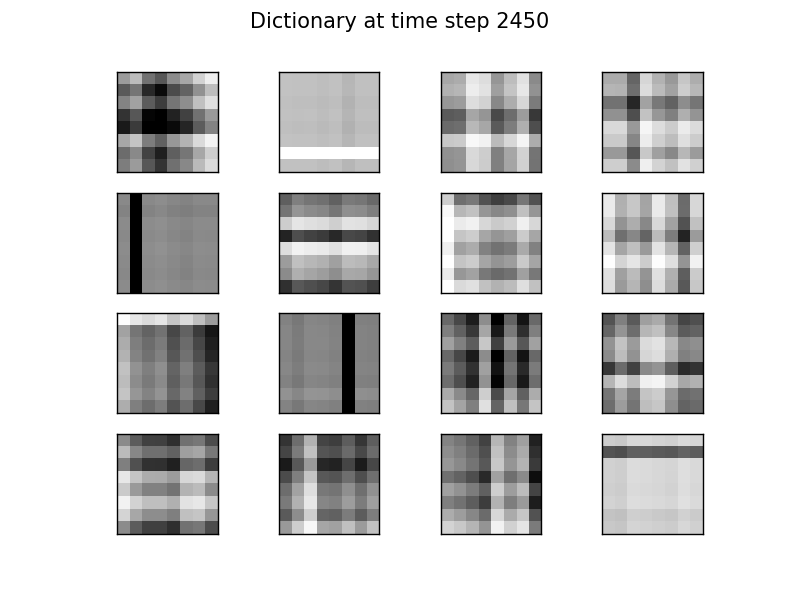

<IPython.core.display.Javascript object>


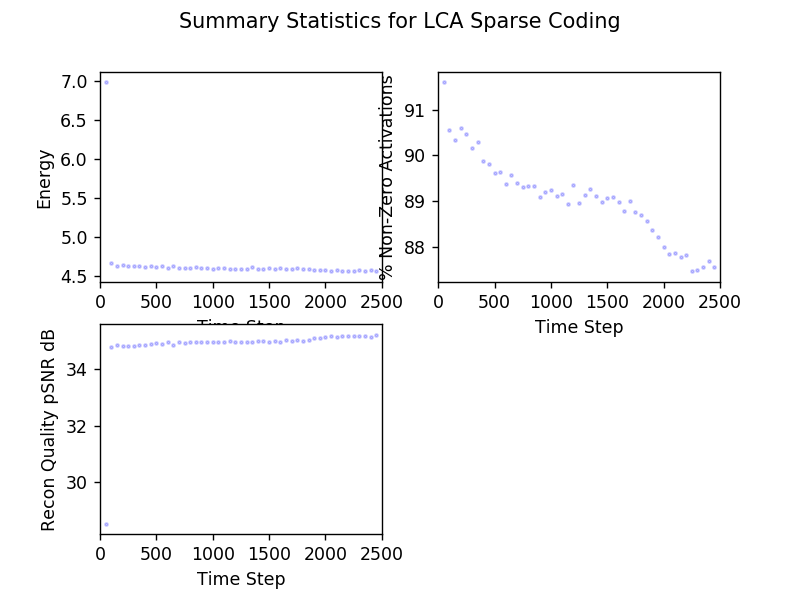

In [48]:
trainModel(bars_dataset, "bars")

<b>ANSWER:</b> A few of the basis functions learn solid horizontal/vertical bars, but the majority appear to be noisy combinations of many bars.  Since the data set no longer has sparse structure, it is difficult to find sparse representations of the images.

## 2. Sparse Coding of Image Patches using the locally competitive algorithms (LCA)

In this second problem we will run the LCA algorithm on images rather than bars. The training data is obtained by extracting small image patches from whitened natural scenes, which one can think of as an idealization of the input provided by the LGN, as we discussed in class when learning about whitening transforms.

Run the algorithm using 100 output neurons on 10x10 pixel image patches. 

Investigate the effects of varying the $\lambda$ parameters as well as the degree of overcompleteness (ratio of numOutputNeurons to numInputNeurons). 

In [59]:
# Load images and view them
images_dataset = np.load("data/IMAGES.npz")['arr_0']
[pixelsCols, pixelsRows, numImages] = images_dataset.shape
numPixels = pixelsCols * pixelsRows
images_dataset = images_dataset.reshape(numPixels, numImages)
images_dataset /= np.sqrt(np.var(images_dataset)) # We want the dataset to have variance=1

In [76]:
# General sparse coding parameters
numTrials = 5000 # Number of weight update steps
numInputs = 100
numOutputs = 100 # Number of sparse coding neurons
lambdav = 0.5 #Lambda parameter that determines how sparse the model will be
batchSize = 50 # Number of samples to use in a single weight update
eta = 0.1 # Learning rate

# LCA specific parameters
tau = 25 # LCA update time constant
numInferenceSteps = 20 # Number of iterations to run LCA

# Plot display parameters
displayInterval = 50 # How often to update display plots during learning
displayStatsInterval = 50

<IPython.core.display.Javascript object>


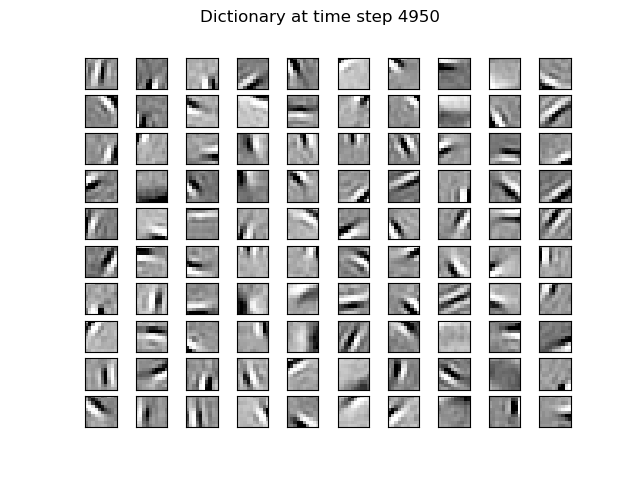

<IPython.core.display.Javascript object>


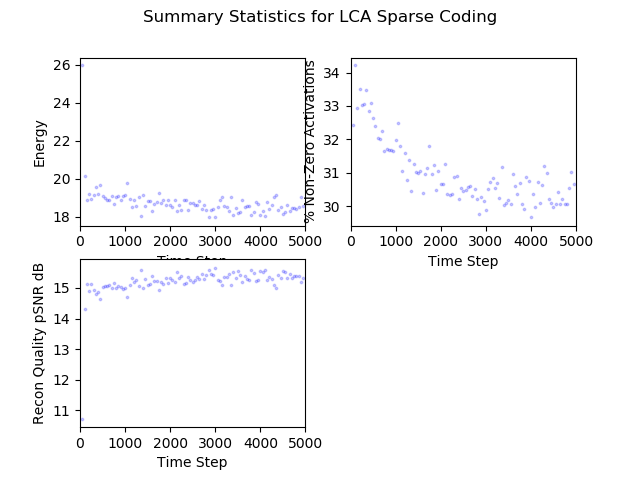

In [77]:
trainModel(images_dataset, "images")

<b>YOUR ANSWER HERE:</b> What is the effect of changing the sparsity tradeoff parameter, $\lambda$? Optional: What other variables affect learning and how?  <b>Answer: </b>Increasing the value of $\lambda$ encourages the learning of a sparse representation, which means the basis functions converge to localized, oriented Gabor filters.  We note that with an overcomplete representation, you can still achieve good reconstruction quality without the sparseness constraint.  In the other extreme, a very large value of $\lambda$ discourages the activation of multiple neurons, which is generally needed to accurately represent images.  The learning rate, $\eta$, affects the magnitude of change in basis functions during each update step.  The number of inference steps used in LCA affects the accuracy of learned activiation coefficients, which is then used in updating the basis functions.  The batch size determines the number of images presented to the network before each weight update is performed.

Now try increasing the size of the network to 200 (or more) output neurons or decreasing it to 50 (or fewer) output neurons. How do the learned features change as you modify the degree of overcompleteness?

<b>YOUR ANSWER HERE:</b> When we increased the number of output neurons, we had to also increase the sparsity tradeoff parameter, $\lambda$ in order to maintain a majority of learned Gabor filters.  With fewer output neurons, Gabor filters are still learned, but the reconstruction quality is poor since there are no longer enough basis functions to properly represent the data. 